# Fitting at one z

In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from astropy.table import Table
from lace.cosmo import camb_cosmo, fit_linP
from pcross_model_forestflow import load_emulator, load_arinyo, get_pcross_forestflow
from likelihood import Likelihood_Pcross, vary_params
from tools import LAMBDA_LYA
sys.path.insert(0, '/global/homes/m/mabdulka/Software/LyaP3D')
sys.path.insert(0, '/global/homes/m/mabdulka/Software/FitLyaP3D/Forestflow')
from iminuit import Minuit

In [10]:
# Redshift
z = 2.2

In [26]:
# set our cosmo (fixed)
omnuh2 = 0.0006
mnu = omnuh2 * 93.14
H0 = 67.36
omch2 = 0.12
ombh2 = 0.02237
As = 2.1e-9
ns = 0.9649
nrun = 0.0
w = -1.0
omk = 0
cosmo = {
    'H0': H0,
    'omch2': omch2,
    'ombh2': ombh2,
    'mnu': mnu,
    'omk': omk,
    'As': As,
    'ns': ns,
    'nrun': nrun,
    'w': w
}



In [27]:
sim_cosmo = camb_cosmo.get_cosmology_from_dictionary(cosmo)
dAA_dMpc_zs = camb_cosmo.dAA_dMpc(sim_cosmo, np.array([z]), LAMBDA_LYA)
dkms_dMpc_zs = camb_cosmo.dkms_dMpc(sim_cosmo, np.array([z]))

In [15]:
# If we want to fix any of these, do it at: z=2.2 parameters from Michael's paper 1808.04367 table 4
initial_mF = 0.825
initial_T0 = 1.014 * 1e4
initial_gamma = 1.74
initial_lambda_pressure = 79.4

In [19]:
z

2.2

In [28]:
pivot_k = 0.7 # Mpc^-1
# compute Delta_P and n_P
linP_zs = fit_linP.get_linP_Mpc_zs(sim_cosmo, [z], pivot_k) # here z could be an array of zs if desired (e.g., [2.2, 2.4, 2.6])

## Reading desi data: Pcross at z=2.2 with fit_snr weighting and covmat

In [16]:
Pcross = Table.read('/global/homes/m/mabdulka/P3D/DESI_IRON_analysis/Full_analysis/Pcross_measurement/DESI_binning/output_2.2/Pcross_measured_AA_PnoiseSubtraction_noResoCorr_noResoCut_SNRweighting_fitforestsnr_withcovmat_2.2.fits.gz')

In [17]:
mean_ang_separation_deg = np.array(Pcross['mean_ang_separation'])

In [18]:
k_parallel_AA = Pcross['k_parallel_rebinned'][1]

In [36]:
k_parallel_AA = np.array([0.08925, 0.26775, 0.44625, 0.62475, 0.80325, 0.98175, 1.16025,
       1.33875, 1.51725, 1.69575, 1.87425, 2.05275, 2.23124, 2.40974,
       2.58824, 2.76674, 2.94524, 3.12374, 3.30224, 3.48074, 3.65924,
       3.83774]) # Martine: I put this in because I can't read your file

In [46]:
mean_ang_separation_deg = np.array([0.        , 0.01214965, 0.0315861 , 0.05049507, 0.06501203,
       0.07540583, 0.0849924 , 0.0948946 , 0.10525764, 0.11518623,
       0.12517739, 0.13523737, 0.1450036 , 0.15507418, 0.16504229,
       0.17509879, 0.18501545, 0.19507285, 0.20500121, 0.21521826,
       0.22520216, 0.2349016 , 0.24509918, 0.2550668 , 0.26510843,
       0.27496408, 0.28508226 , 0.29487144, 0.35228993, 0.45169857,
       0.55142291]) # Martine: I put this in because I can't read your file

## Create Pcross data having shape (# theta, # kpar)

In [21]:
pcross_data = np.array(Pcross['corrected_power_spectrum_rebinned'])
error_pcross_data = np.array(Pcross['error_corrected_power_spectrum_rebinned'])

In [22]:
np.shape(pcross_data)

(31, 22)

## Emulation part

In [30]:
import time

In [31]:
# Load emulator
start_time_emulator = time.time()
forestflow_emulator = load_emulator()
end_time_emulator = time.time()
print(f"Execution time: {end_time_emulator - start_time_emulator:.4f} seconds")

Execution time: 13.2191 seconds


/Users/mlokken/research/lyman_alpha/software/ForestFlow/forestflow/P3D_cINN.py:675: UserWarning: Loading a pre-trained emulator
  warn("Loading a pre-trained emulator")


In [39]:
from pcross_model_forestflow import get_forestflow_params
igm_param_dict = {
        "mF": initial_mF,
        "gamma": initial_gamma,
        "lambda_pressure": initial_lambda_pressure,
        "T0": initial_T0,
    }
emu_params, info_power = get_forestflow_params(z, igm_param_dict, cosmo, dkms_dMpc_zs)

In [40]:
forestflow_emulator.Nrealizations

100

In [42]:
# just for testing
# %%prun -s cumulative -q -l 20 -T emulator_run1
# forestflow_emulator.evaluate(emu_params, info_power)

In [41]:
# Load arinyo with fixed cosmo
arinyo_model = load_arinyo(z, cosmo)

In [43]:
inout_unit = 'AA'
sepbins_unit = 'deg'

In [55]:
Px = get_pcross_forestflow(k_parallel_AA, mean_ang_separation_deg, z, cosmo, sim_cosmo, dAA_dMpc_zs, dkms_dMpc_zs, 
                                  forestflow_emulator, arinyo_model, inout_unit, sepbins_unit, 
                                  linP_zs[0]['Delta2_p'], linP_zs[0]['n_p'],
                      initial_mF, initial_T0, initial_gamma, initial_lambda_pressure)

Input parameters given to the emulator are: {'mF': 0.825, 'gamma': 1.74, 'sigT_Mpc': 0.13114502262703392, 'kF_Mpc': 12.594458438287152} {'Delta2_p': 0.5488196277178482, 'n_p': -2.3027803728304876, 'z': 2.2}


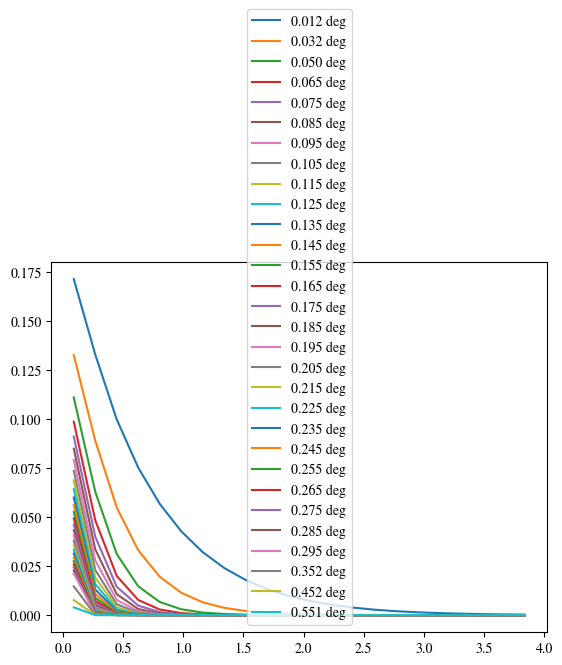

In [62]:
for sepbin in range(1, len(mean_ang_separation_deg)):
    plt.plot(k_parallel_AA, Px[sepbin], label=f'{mean_ang_separation_deg[sepbin]:.3f} deg')
# plt.xscale('log')

plt.legend()

In [37]:
%%prun -s cumulative -q -l 20 -T prun3
get_pcross_forestflow(k_parallel_AA, mean_ang_separation_deg, z, cosmo, sim_cosmo, dAA_dMpc_zs, dkms_dMpc_zs,
                                  forestflow_emulator, arinyo_model, inout_unit, sepbins_unit, 
                      initial_mF, initial_T0, initial_gamma, initial_lambda_pressure)

 
*** Profile printout saved to text file 'prun3'.


# Likelihood

## Define the wrapped model

In [38]:
def wrapper_get_pcross_forestflow(mF, T0, gamma, lambda_pressure):
    return get_pcross_forestflow(k_parallel_AA, mean_ang_separation_deg, z, cosmo, sim_cosmo, dAA_dMpc_zs, dkms_dMpc_zs,
                                  forestflow_emulator, arinyo_model, inout_unit, sepbins_unit, mF, T0, gamma, lambda_pressure)

In [39]:
minimize_chi_square = True

In [40]:
likelihood_pcross = Likelihood_Pcross(
    model=wrapper_get_pcross_forestflow, 
    y_data=pcross_data, 
    y_err=error_pcross_data,
    minimize_chi_square=minimize_chi_square)

In [41]:
likelihood_pcross

#### 1st model

In [59]:
mF_central = 0.825
mF_1 = [mF_central- (mF_central * 0.1), mF_central, mF_central + (mF_central * 0.1)]
T0_1 = 1.014 * 1e4
gamma_1 = 1.74
lambda_pressure_1 = 79.4
model_1_list = []
chi_2_1_list = []

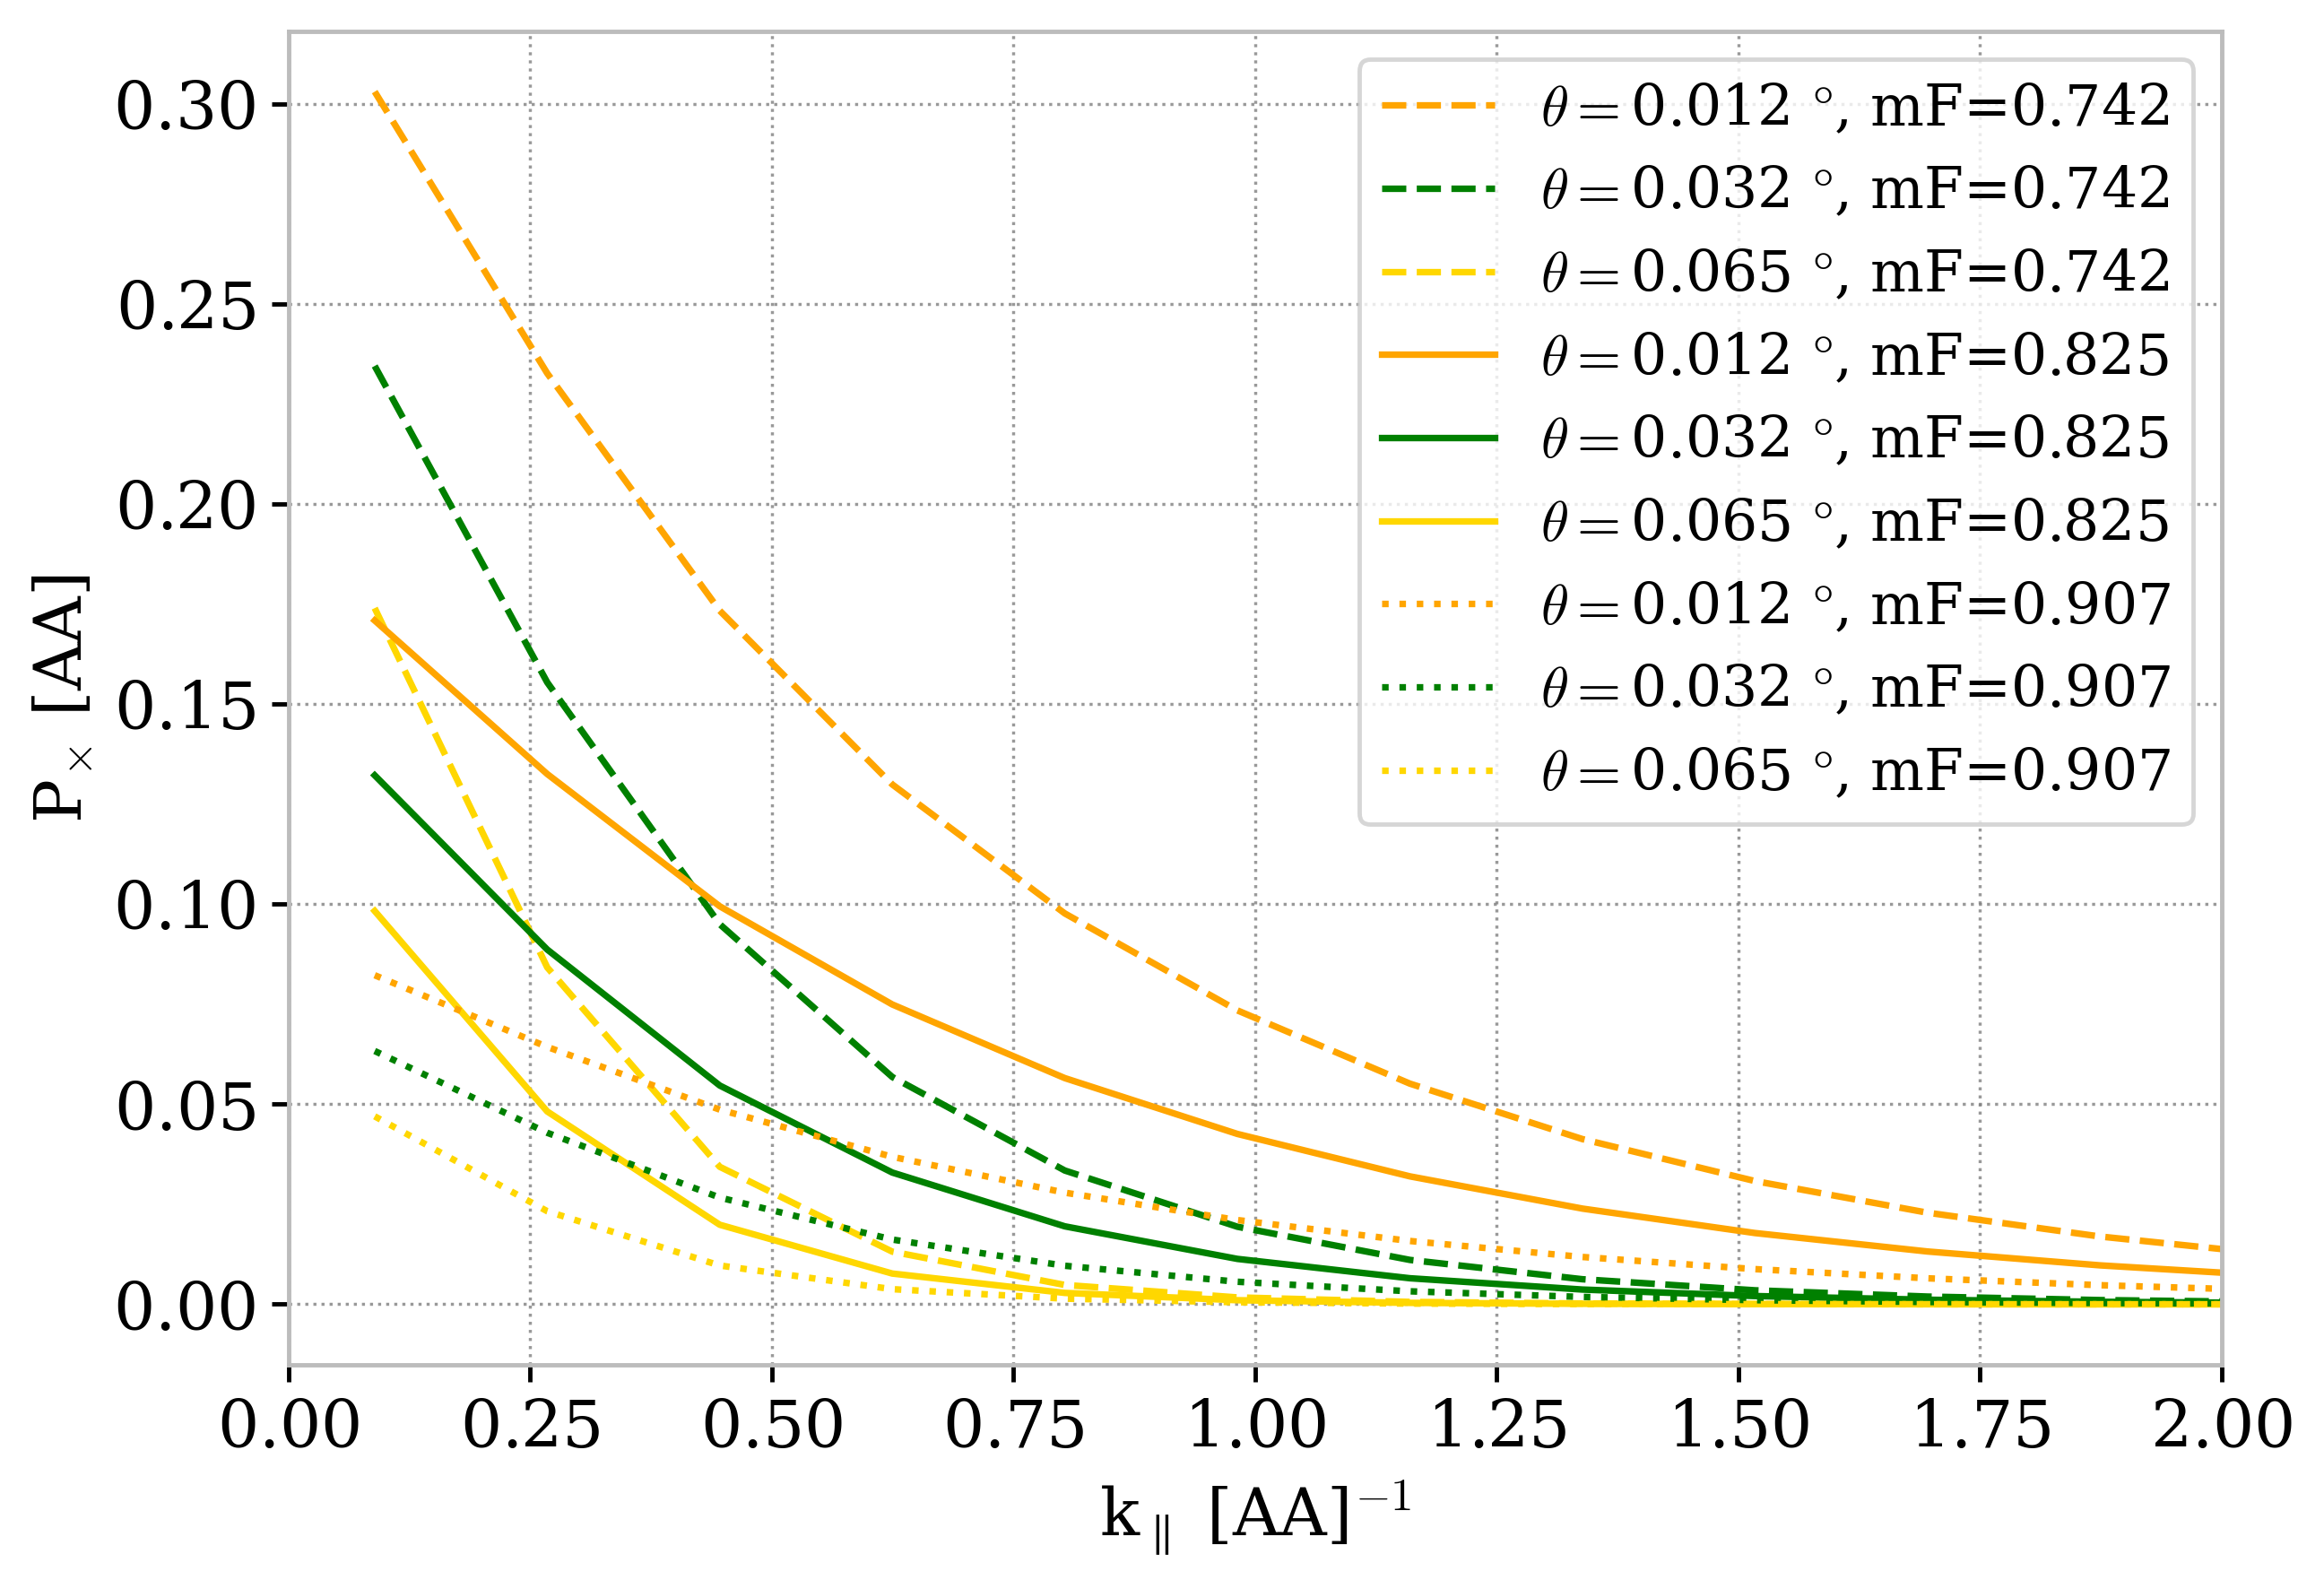

In [60]:
colors = ['blue', 'orange', 'green', 'red', 'gold', 'purple', 'black',  'mediumslateblue', 'violet', 'yellow', 'brown', 'grey',
          'orchid', 'silver', 'crimson', 'pink', 'coral', 'maroon', 'cyan', 'magenta']
plt.style.use("/global/homes/m/mabdulka/Software/style.mplstyle")
plt.rcParams["figure.figsize"] = (7,5)
plt.figure()
for index_mF, mF_1_i in enumerate(mF_1):
    model_1_i, chi2_1_i = likelihood_pcross(mF_1_i, T0_1, gamma_1, lambda_pressure_1)
    model_1_list.append(model_1_i)
    chi_2_1_list.append(chi2_1_i)
    ls_list = ['dashed', 'solid', 'dotted', 'dashdot']
    for i in [1, 2, 4]:
        plt.plot(k_parallel_AA, model_1_i[i],
                    label='$\\theta = $'+'{:.3f}'.format(mean_ang_separation_deg[i])+' $\degree$, mF='+'{:.3f}'.format(mF_1_i), 
                 color=colors[i], ls = ls_list[index_mF])
plt.legend(ncol=1)
plt.ylabel(r'P$_{\times}$ [AA]')
plt.xlabel('k$_{\parallel}$ [AA]$^{-1}$')
plt.xlim((0, 2))
plt.tight_layout
plt.show()

## Second model

In [62]:
mF_central = 0.825
mF_2 = mF_central
T0_2 = 1.014 * 1e4
gamma_2 = [initial_gamma-.1*initial_gamma, initial_gamma, initial_gamma+.1*initial_gamma]
lambda_pressure_2 = 79.4
model_2_list = []
chi_2_2_list = []

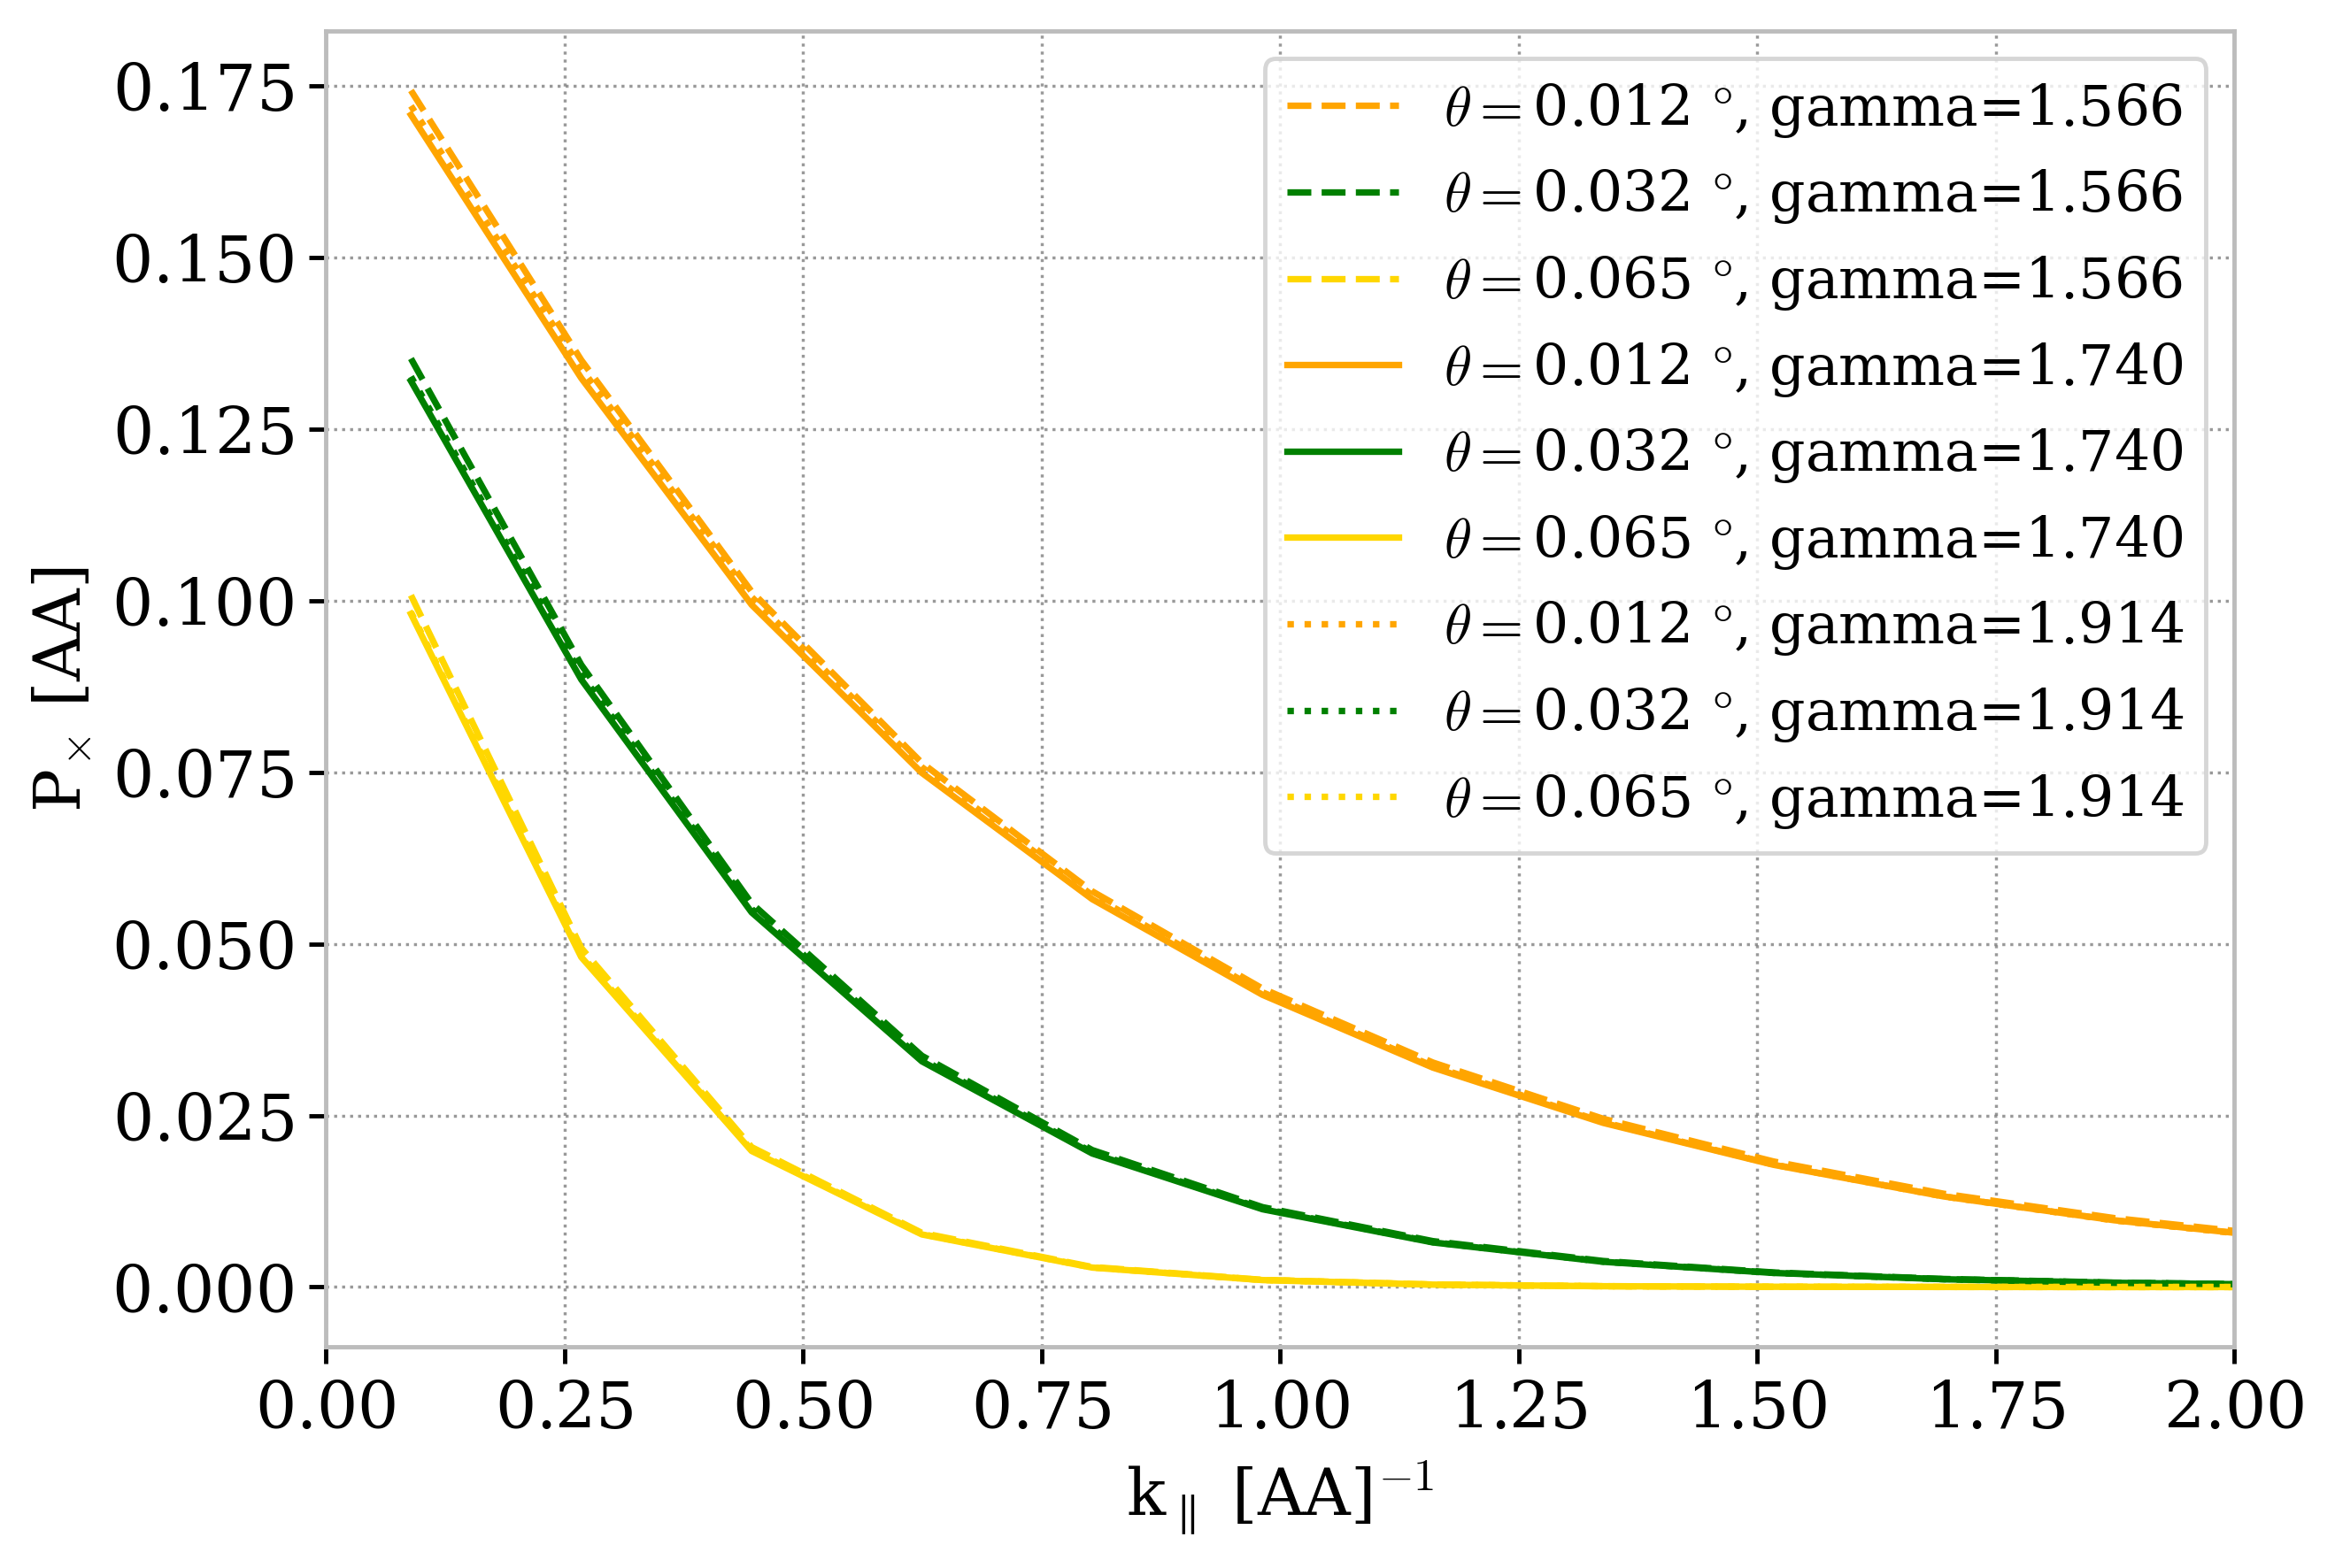

In [67]:
colors = ['blue', 'orange', 'green', 'red', 'gold', 'purple', 'black',  'mediumslateblue', 'violet', 'yellow', 'brown', 'grey',
          'orchid', 'silver', 'crimson', 'pink', 'coral', 'maroon', 'cyan', 'magenta']
plt.style.use("/global/homes/m/mabdulka/Software/style.mplstyle")
plt.rcParams["figure.figsize"] = (7,5)
plt.figure()
for index_gam, gam_2_i in enumerate(gamma_2):
    model_2_i, chi2_2_i = likelihood_pcross(mF_2, T0_2, gam_2_i, lambda_pressure_2)
    model_2_list.append(model_2_i)
    chi_2_2_list.append(chi2_2_i)
    ls_list = ['dashed', 'solid', 'dotted', 'dashdot']
    for i in [1, 2, 4]:
        plt.plot(k_parallel_AA, model_2_i[i],
                    label='$\\theta = $'+'{:.3f}'.format(mean_ang_separation_deg[i])+' $\degree$, gamma='+'{:.3f}'.format(gam_2_i), 
                 color=colors[i], ls = ls_list[index_gam])
plt.legend(ncol=1)
plt.ylabel(r'P$_{\times}$ [AA]')
plt.xlabel('k$_{\parallel}$ [AA]$^{-1}$')
plt.xlim((0, 2))
plt.tight_layout
plt.show()

### 1- Varying T0 and gamma

#### Minuit object

In [36]:
m_pcross_1 = Minuit(likelihood_pcross, 
                    name=("mF", "T0", "gamma", "lambda_pressure"),
                    mF=0, T0=0, gamma=initial_gamma, lambda_pressure=initial_lambda_pressure)

In [37]:
m_pcross_2

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,mF,0.0,0.1,,,,,
1,T0,0.0,0.1,,,,,
2,gamma,1.740,0.017,,,,,
3,lambda_pressure,79.4,0.8,,,,,


In [38]:
m_pcross_1 = vary_params(m_pcross_1, ["T0", "gamma"])
print(m_pcross_1.params)

┌───┬─────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name            │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mF              │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 1 │ T0              │    0.0    │    0.1    │            │            │         │         │       │
│ 2 │ gamma           │   1.740   │   0.017   │            │            │         │         │       │
│ 3 │ lambda_pressure │   79.4    │    0.8    │            │            │         │         │  yes  │
└───┴─────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘


In [39]:
m_pcross_1.limits["T0"] = (5000, 15000)
m_pcross_1.limits["gamma"] = (0.8, 3.5)

In [40]:
m_pcross_1

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,mF,0.0,0.1,,,,,yes
1,T0,5.0000e3,0.0001e3,,,5E+03,1.5E+04,
2,gamma,1.740,0.017,,,0.8,3.5,
3,lambda_pressure,79.4,0.8,,,,,yes


In [41]:
start_time_minuit = time.time()
m_pcross_1.migrad()
m_pcross_1.hesse()
m_pcross_1.minos()
end_time_miniuit = time.time()
print(f"Execution time: {end_time_miniuit - start_time_minuit:.4f} seconds")

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fe97616b550>>
Traceback (most recent call last):
  File "/global/common/software/desi/users/mabdulka/conda/forestflow/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fe97616b550>>
Traceback (most recent call last):
  File "/global/common/software/desi/users/mabdulka/conda/forestflow/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fe97616b550>>
Traceback (most recent call last):
  File "/global/common/soft

KeyboardInterrupt: 